# Stats Workflow

**Cara Piske, Graduate Program of Hydrologic Sciences, 2022; Advisor: Dr. Adrian Harpold**<br>
This code processes lidar-derived rasters to evaluate the difference between snow properties (SWE) in under vs. open canopy classifications. <br>
Lidar data were provided by the Airborne Snow Observatory (ASO), the National Center for Airborne Laser Mapping (NCALM), and Watershed Sciences Inc. (WSI). <br>

See: Varhola, A., Coops, N. C., Weiler, M., & Moore, R. D. (2010). Forest canopy effects on snow accumulation and ablation: An integrative review of empirical results. In Journal of Hydrology (Vol. 392, Issues 3–4, pp. 219–233). Elsevier. https://doi.org/10.1016/j.jhydrol.2010.08.009 <br>
and<br>
Kostadinov, T. S., Schumer, R., Hausner, M., Bormann, K. J., Gaffney, R., McGwire, K., Painter, T. H., Tyler, S., & Harpold, A. A. (2019). Watershed-scale mapping of fractional snow cover under conifer forest canopy using lidar. Remote Sensing of Environment, 222, 34–49. https://doi.org/10.1016/j.rse.2018.11.037

In [1]:

# import necessary packages 
from osgeo import gdal, ogr, osr
import csv
import os
import subprocess
import sys
import pdal
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import time
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import subprocess
import statsmodels.api as sm

# competing paths on our PC 
gdal_merge = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_merge.py')
gdal_calc = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_calc.py')
gdal_warp = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_warp.py')
gdal_polygonize = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_polygonize.py')
gdal_proximity = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_proximity.py')

In [2]:
#make sure we're in the right working directory
os.chdir('/')
print(os.getcwd())

G:\


## Load Data

In [3]:
# input - path = str. i.e. 'SCB/kane_veg_metrics/departure/14_withholes/departure_wh_clip2dem.tif'
# input - nd_value = int. no data value
# output - raster_arr = 1D array of raster values (maintaining columns)
def raster_to_array(path, nd_value):
    raster = gdal.Open(path) # open the file 
    raster_arr = raster.GetRasterBand(1).ReadAsArray() #read the first raster band (in this case we know we are only working with single bands) and read to a 2D array
    if raster_arr.dtype == 'int32':
        raster_arr = raster_arr.astype(float)
    raster_arr[raster_arr == nd_value] = np.nan # where the raster is equal to the provided no data value, set values to Nan
    raster_arr_flat = raster_arr.flatten() # flatten the array (row-wise)
    raster = None
    return raster_arr_flat

#### Get raster metadata

In [1]:
SCB_elev = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_BE_30m.tif'

In [5]:
# open slope and aspect as arrays
elev_ras = gdal.Open(SCB_elev) # open the file 
# save spatial data
gt = elev_ras.GetGeoTransform()
proj = elev_ras.GetProjection()

elev_ras = None # close rasters

# Vegetation and Terrain

### Load Data- Create DataFrame

In [8]:
# terrain variables
DEM_arr = raster_to_array('MRB/Merced_lidar/NCALM/NCALM_MRB_20180921/DEM/NCALM_MRB_20180921_BE_30m.tif', -9999)
nness_arr = raster_to_array('MRB/Merced_lidar/NCALM/NCALM_MRB_20180921/DEM/NCALM_MRB_20180921_nness_30m.tif', -9999)

In [22]:
# vegetation variables
fVEG_arr = raster_to_array('MRB/Merced_lidar/NCALM/NCALM_MRB_20180921/CHM_merge/NCALM_MRB_20180921_fVeg.tif', -9999)
fVEG_arr[fVEG_arr<0] = np.nan

In [23]:
terain_veg_dict = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
})
elev_bins_set = ([1800,2000,2100,2200,2300,2400,2800])
nness_bins_set = ([-0.6,-0.3,0,0.3,0.6])
fVEG_bins_set = ([0,0.25,0.5, 0.75, 1.0])

In [24]:
terain_veg_dict['nness_bins'] = pd.cut(terain_veg_dict['nness'], bins=nness_bins_set, right = False,include_lowest= True)
terain_veg_dict['elev_bins'] = pd.cut(terain_veg_dict['elev'], bins=elev_bins_set, right = False,include_lowest= True)
terain_veg_dict['fVeg_bins'] = pd.cut(terain_veg_dict['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)

#### Plot

**Elevation, Nness, Slope**

Text(0.5, 0, 'fVeg')

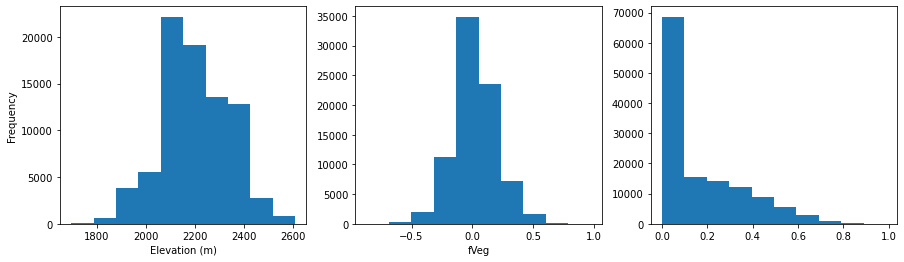

In [25]:
# plot elevation vs. snow depth and fsca (mean)
terrain_hist, axs = plt.subplots(1, 3, figsize =(15,4));
axs[0].hist(terain_veg_dict['elev']); axs[0].set_xlabel('Elevation (m)'); axs[0].set_ylabel('Frequency')
axs[1].hist(terain_veg_dict['nness']); axs[1].set_xlabel('Northness')
axs[2].hist(terain_veg_dict['fVeg']); axs[1].set_xlabel('fVeg')

#terrain_hist.savefig('lidar_processing/python_scripts/snow_departure_project/figures/terrain_variable_histogram.png')

In [ ]:
elev nness fveg

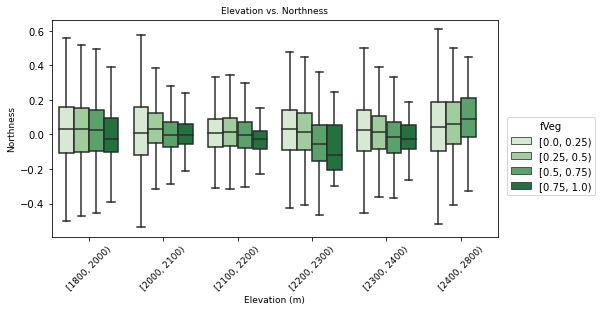

In [26]:
elev_nness_fveg_fig, axes = plt.subplots(1,1,figsize=(8, 4), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=terain_veg_dict, x='elev_bins', y="nness", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes.set_title('Elevation vs. Northness', fontsize = 9); axes.set_xlabel('Elevation (m)', fontsize = 9); axes.set_ylabel('Northness', fontsize = 9)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 9)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'fVeg')
#elev_nness_slope_fig.savefig('AGU/box_figs/terrain_veg/nness_elev_GapSize.png',transparent=True,bbox_inches='tight')

terrain vs fveg

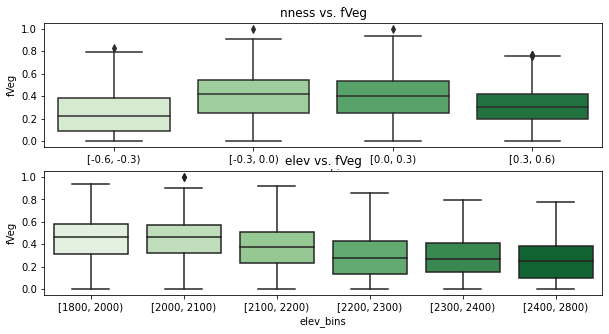

In [99]:
nness_fveg_box, axes = plt.subplots(2,1,figsize=(10, 5), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=terain_veg_dict, x='nness_bins', y="fVeg", palette = 'Greens') #, hue = 'nness_bins'
axes[0].set_title('nness vs. fVeg'); #axes.set(xlabel = 'Vegetation Departure',ylabel = 'Northness'); axes.set_xticklabels(axes.get_xticklabels(),rotation = 45);
#dep_nness_box.savefig('lidar_processing/python_scripts/snow_departure_project/figures/dep_nness_box.png')
sns.boxplot(ax=axes[1], data=terain_veg_dict, x='elev_bins', y="fVeg", palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('elev vs. fVeg');

# Delta Change in Snowpack Properties
We'll start off using only our best estimate of snowpack accumulation, which is the earliest flight available from each year. <br>

## Accumulation
Calculated as the difference between open and tall snowpack

### Load Data - Create Dataframe

In [42]:
# Start with the ASO flight
ASO_20180425_open = 'MRB/Merced_lidar/ASO/ASO_MRB_20180425/snow_depth/ASO_MRB_20180425_SD_open_30m.tif'
ASO_20180425_tall = 'MRB/Merced_lidar/ASO/ASO_MRB_20180425/snow_depth/ASO_MRB_20180425_SD_tall_30m.tif'
ASO_20180425_all = 'MRB/Merced_lidar/ASO/ASO_MRB_20180425/snow_depth/ASO_MRB_20180425_SD_30m.tif'
ASO_20180425_delta_acc_open = 'MRB/Merced_lidar/ASO/ASO_MRB_20180425/snow_depth/ASO_MRB_20180425_delta_acc.tif'
#ASO_delta_acc_tall = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation_tallRef.tif'


In [38]:
# # delta_accumulation_cmd = ['python',gdal_calc, '-A', NCALM_2008_open,'-B',NCALM_2008_all,'--NoDataValue','-9999',
# #  '--outfile', NCALM_delta_acc, '--calc="(B-A)/A*100"','--overwrite']
# # subprocess.run(delta_accumulation_cmd)

# delta_accumulation_cmd = ['python',gdal_calc, '-A', ASO_20180425_open,'-B',ASO_20180425_all,'--NoDataValue','-9999',
#  '--outfile', ASO_20180425_delta_acc_open, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(delta_accumulation_cmd)


CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'MRB/Merced_lidar/ASO/ASO_MRB_20180425/snow_depth/ASO_MRB_20180425_SD_open_30m.tif', '-B', 'MRB/Merced_lidar/ASO/ASO_MRB_20180425/snow_depth/ASO_MRB_20180425_SD_30m.tif', '--NoDataValue', '-9999', '--outfile', 'MRB/Merced_lidar/ASO/ASO_MRB_20180425/snow_depth/ASO_MRB_20180425_delta_acc.tif', '--calc="(B-A)/A*100"', '--overwrite'], returncode=0)

In [39]:
# load into array
SD_180825_arr = raster_to_array(ASO_20180425_all, -9999)
SD_180825_delta_acc_arr = raster_to_array(ASO_20180425_delta_acc_open, -9999)
#ASO_delta_acc_arr_tall = raster_to_array(ASO_delta_acc_tall, -9999)

In [43]:
acc_df = terain_veg_dict = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
    'SD_180825': SD_180825_arr,
    'SD_180825_delta_acc_arr': SD_180825_delta_acc_arr,
})
acc_df['nness_bins'] = pd.cut(acc_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
acc_df['elev_bins'] = pd.cut(acc_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
acc_df['fVeg_bins'] = pd.cut(acc_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
elev_bins_arr = acc_df['elev_bins'].unique()
elev_bins_arr_sort = [elev_bins_arr.categories[0],elev_bins_arr.categories[1], elev_bins_arr.categories[2],elev_bins_arr.categories[3],elev_bins_arr.categories[4],elev_bins_arr.categories[5]] # create a new list with sorted values

## Ablation

### Load Data - Create Dataframe

In [302]:
ASO_0326_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_open_buffered_30m.tif'
ASO_0326_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_30m.tif'
ASO_0417_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_open_buffered_30m.tif'
ASO_0417_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_30m.tif'
ASO_0518_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE_open_buffered_30m.tif'
ASO_0518_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE_30m.tif'

In [339]:
ASO_abl_MarApr_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarApr_open.tif'
ASO_abl_MarApr_all = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarApr_all.tif'
ASO_delta_abl_MarApr = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_MarApr.tif'

ASO_abl_MarMay_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay_open.tif'
ASO_abl_MarMay_all = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay_all.tif'
ASO_delta_abl_MarMay = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_MarMay.tif'

ASO_abl_AprMay_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_AprMay_open.tif'
ASO_abl_AprMay_all = 'SCB/stats/delta_ablation_rasters/ASO_abl_AprMay_all.tif'
ASO_delta_abl_AprMay = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_AprMay.tif'

In [439]:
# snow_cmd = ['python',gdal_calc, '-A', ASO_0417_open,'-B',ASO_0518_open,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_AprMay_open, '--calc="A-B"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_0417_all,'-B',ASO_0518_all,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_AprMay_all, '--calc="A-B"','--overwrite']
# subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarMay_open,'-B',ASO_abl_MarMay_all,'--NoDataValue','-9999',
 '--outfile', ASO_delta_abl_MarMay, '--calc="(B-A)/A*100"','--overwrite']
subprocess.run(snow_cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay_open.tif', '-B', 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay_all.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_MarMay.tif', '--calc="(B-A)/A*100"', '--overwrite'], returncode=0)

In [440]:
ASO_delta_abl_MarApr_arr = raster_to_array(ASO_delta_abl_MarApr, -9999)
ASO_delta_abl_MarMay_arr = raster_to_array(ASO_delta_abl_MarMay, -9999)
ASO_delta_abl_AprMay_arr = raster_to_array(ASO_delta_abl_AprMay, -9999)
ASO_abl_MarApr_arr = raster_to_array(ASO_abl_MarApr_all, -9999)
ASO_abl_MarMay_arr = raster_to_array(ASO_abl_MarMay_all, -9999)
ASO_abl_AprMay_arr = raster_to_array(ASO_abl_AprMay_all, -9999)

In [469]:
abl_df = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "slope": slope_arr,
    "fVeg": fVEG_arr,
    "DNC": DNC_arr,
    'abl_MarApr': ASO_abl_MarApr_arr,
    'abl_MarMay': ASO_abl_MarMay_arr,
    'abl_AprMay': ASO_abl_AprMay_arr,
    'delta_abl_MarApr': ASO_delta_abl_MarApr_arr,
    'delta_abl_MarMay': ASO_delta_abl_MarMay_arr,
    'delta_abl_AprMay': ASO_delta_abl_AprMay_arr,
})
abl_df['nness_bins'] = pd.cut(abl_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
abl_df['elev_bins'] = pd.cut(abl_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
abl_df['fVeg_bins'] = pd.cut(abl_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)

# Plot

#### Hist

In [550]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM', 'nness_bins', 'elev_bins', 'fVeg_bins',
       'elev_rnd'],
      dtype='object')

Text(0.5, 0, 'SWE 02/10/2008 (cm)')

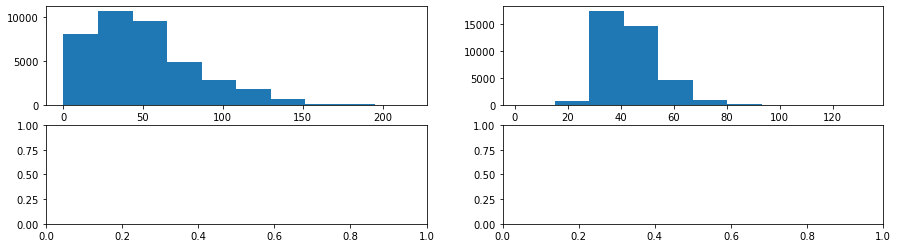

In [555]:
# plot elevation vs. snow depth and fsca (mean)
terrain_hist, axs = plt.subplots(2, 2, figsize =(15,4));
axs[0,0].hist(acc_df['swe_160326']); axs[0,0].set_xlabel('SWE 03/26/2016 (cm)')
axs[0,1].hist(acc_df['swe_080210']); axs[0,1].set_xlabel('SWE 02/10/2008 (cm)')
#axs[1,0].hist(acc_df['delta_acc_ASO']); axs[1,0].set_xlabel('delta_SWE 03/26/2016 (cm)')
#axs[1,1].hist(acc_df['delta_acc_NCALM']); axs[1,1].set_xlabel('delta_SWE 02/10/2008 (cm)')
#terrain_hist.savefig('lidar_processing/python_scripts/snow_departure_project/figures/terrain_variable_histogram.png')

In [249]:
# import matplotlib.ticker as mticker
# SWE_nness_elevBins_scatter, axes = plt.subplots(2,3,figsize=(25, 15), sharey=False, sharex=False) # create a figure axis
# #nness_deltaFSCA_group_box.suptitle('orthness vs. Change in fSCA') # add title to entire figure
# #palette_arr = ['darkorange','lightyellow','lightblue','royalblue']
# for i in range(3):
#     sns.scatterplot(ax=axes[0,i], y = (acc_df['swe_160326'][acc_df['elev_bins'] == elev_bins_arr_sort[i]]), x = (acc_df['nness'][acc_df['elev_bins'] == elev_bins_arr_sort[i]]))
#     axes[0,i].set(xticklabels = [],title = ('Elevation = ' + str(elev_bins_arr_sort[i])), xlabel = '',ylabel = 'SWE (cm) 03/26/2016')

#     sns.scatterplot(ax=axes[1,i], y = (acc_df['swe_160326'][acc_df['elev_bins'] == elev_bins_arr_sort[i+3]]), x = (acc_df['nness'][acc_df['elev_bins'] == elev_bins_arr_sort[i+3]]))
#     axes[1,i].set(title = ('Elevation = ' + str(elev_bins_arr_sort[i+3])), xlabel = 'Northness',ylabel = 'SWE (cm) 03/26/2016')
#     #axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(),rotation = 30, size = 10)
#     # ticks_loc = axes[1,i].get_xticks().tolist()
#     # axes[1,i].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#     # axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(),rotation = 30, size = 10)
# SWE_nness_elevBins_scatter.savefig('SCB/stats/figures/SWE_nness_elevBins_scatter.png')

In [354]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'nness_bins', 'elev_bins',
       'fVeg_bins'],
      dtype='object')

<AxesSubplot:xlabel='fVeg', ylabel='swe_160326'>

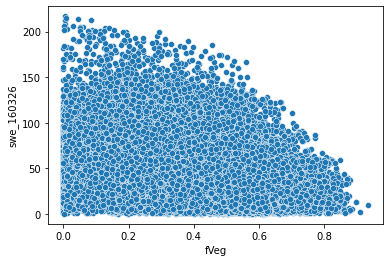

In [355]:
sns.scatterplot(data=acc_df, x="fVeg", y="swe_160326")

<AxesSubplot:xlabel='fVeg', ylabel='delta_acc_tall_ASO'>

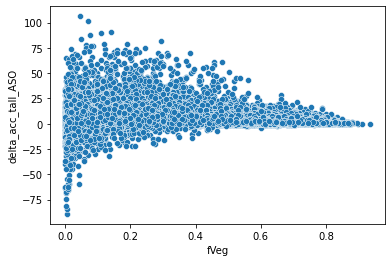

In [380]:
sns.scatterplot(data=acc_df, x="fVeg", y="delta_acc_tall_ASO")

In [394]:
abl_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'abl_MarApr', 'abl_MarMay',
       'abl_AprMay', 'delta_abl_MarApr', 'delta_abl_MarMay',
       'delta_abl_AprMay', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

<AxesSubplot:xlabel='elev', ylabel='abl_MarApr'>

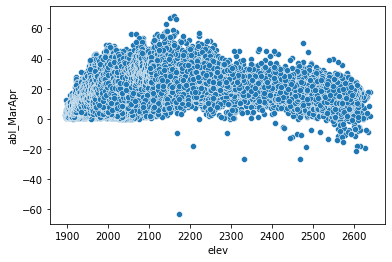

In [478]:
sns.scatterplot(data=abl_df, x="elev", y="abl_MarApr")

<AxesSubplot:xlabel='elev_bins', ylabel='delta_abl_MarMay'>

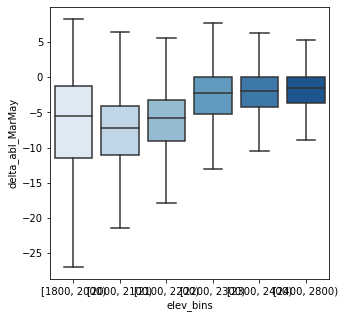

In [412]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(5, 5), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=abl_df, x='elev_bins', y="delta_abl_MarMay",showfliers = False,palette = 'Blues') #, hue = 'nness_bins'


# Final Plots

In [34]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'SD_180825', 'SD_180825_delta_acc_arr',
       'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

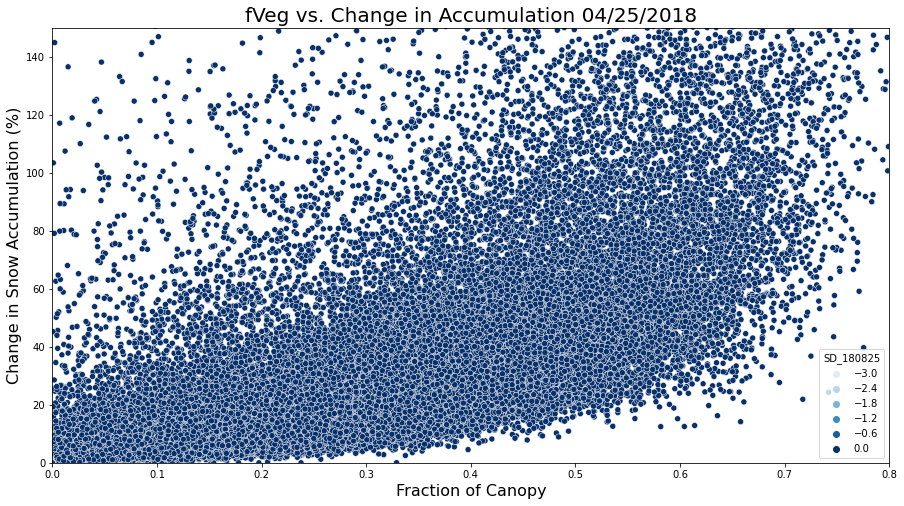

In [50]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=acc_df, x='fVeg', y="SD_180825_delta_acc_arr", hue='SD_180825',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 04/25/2018', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(0, 150),xlim=(0,0.8))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ICB_delta_SD_scatter.png',transparent=True,bbox_inches='tight')

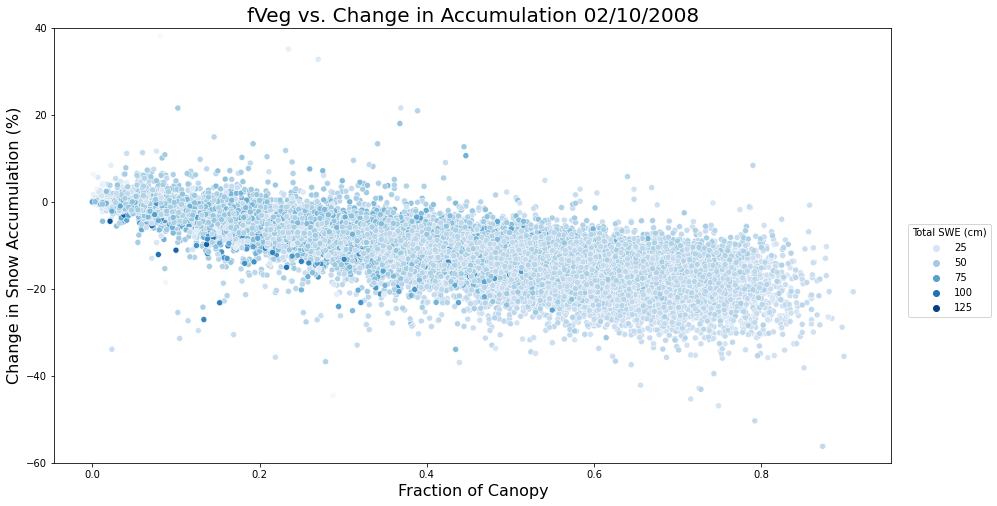

In [559]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=acc_df, x='fVeg', y="delta_acc_NCALM", hue='swe_080210',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 02/10/2008', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

In [434]:
abl_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'abl_MarApr', 'abl_MarMay',
       'abl_AprMay', 'delta_abl_MarApr', 'delta_abl_MarMay',
       'delta_abl_AprMay', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

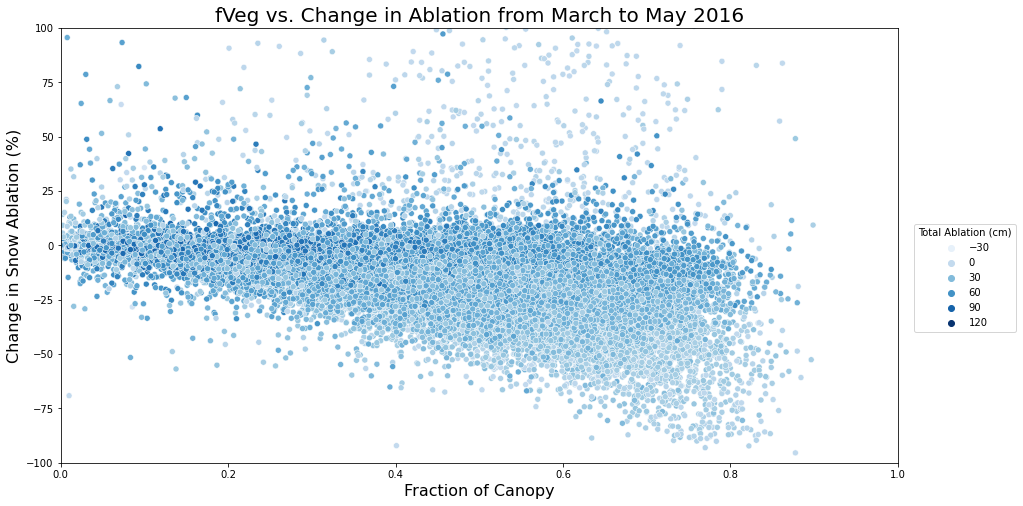

In [574]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_MarMay", hue = 'abl_MarMay', palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Ablation from March to May 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
axes.set(ylim=(-100, 100),xlim=(0,1))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_MarMay_scatter.png',transparent=True,bbox_inches='tight')

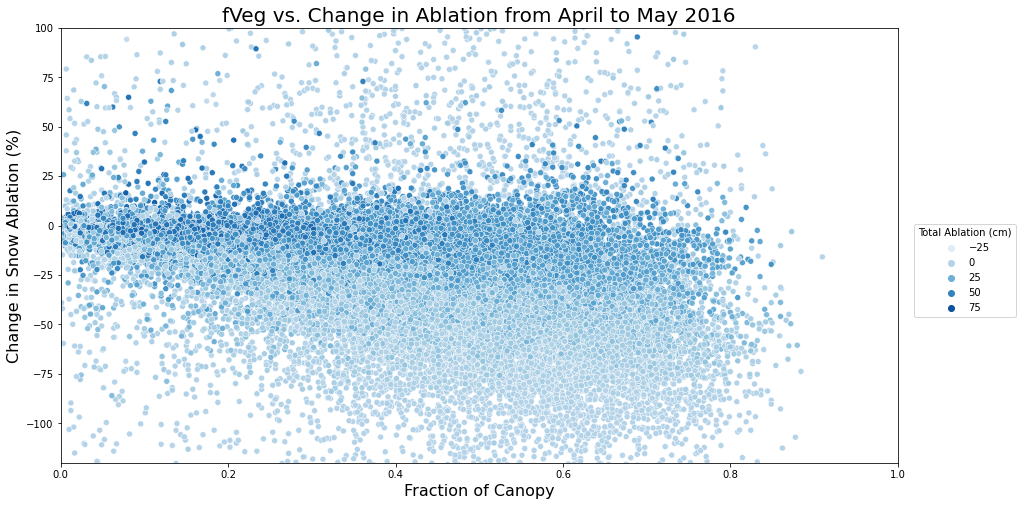

In [576]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_AprMay", hue = 'abl_AprMay', palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Ablation from April to May 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
axes.set(ylim=(-120, 100),xlim=(0,1))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_AprMay_scatter.png',transparent=True,bbox_inches='tight')

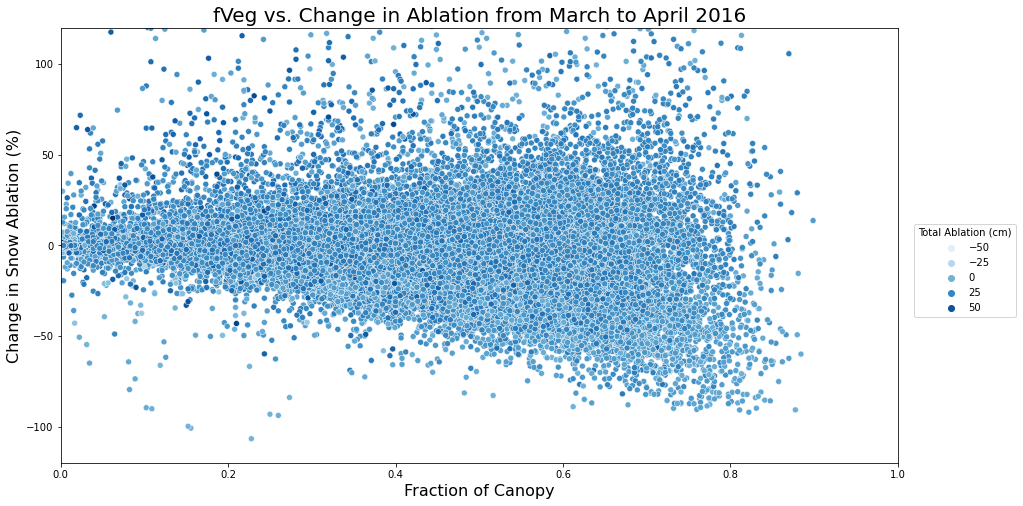

In [579]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_MarApr", hue = 'abl_MarApr', palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Ablation from March to April 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
axes.set(ylim=(-120, 120),xlim=(0,1))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_MarApr_scatter.png',transparent=True,bbox_inches='tight')

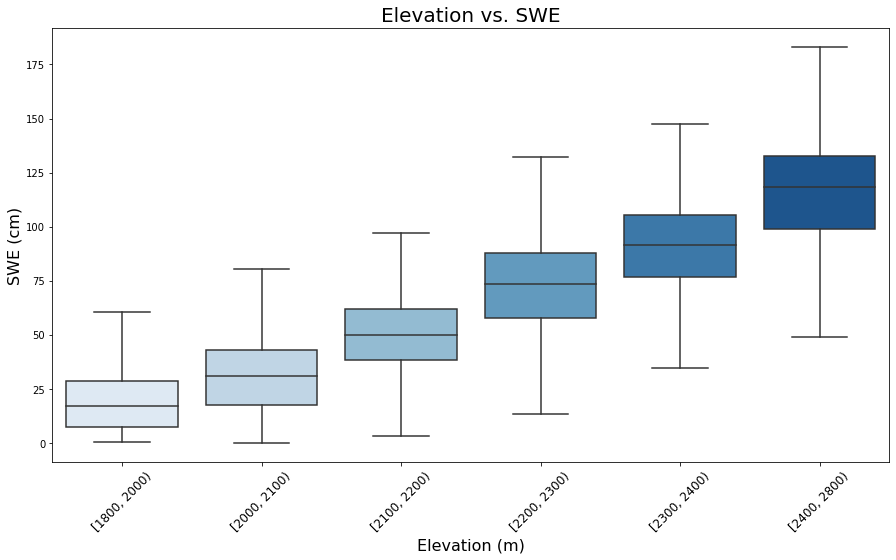

In [163]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_0326",showfliers = False,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Elevation vs. SWE', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

elev_SWE_box.savefig('SCB/stats/figures/elev_SWE_0326_box.png',transparent=True,bbox_inches='tight')

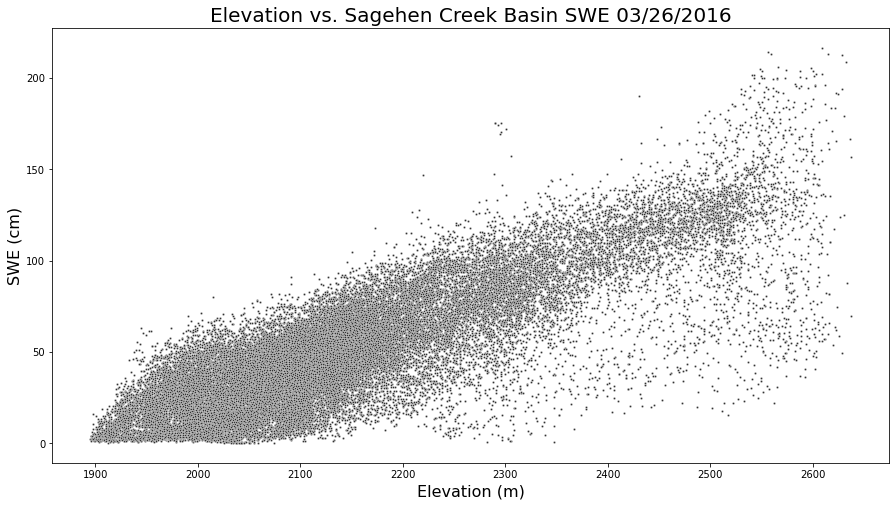

In [188]:
elev_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(data=acc_df, x="elev", y="swe_0326", s=20, color=".2", marker=".")
axes.set_title('Elevation vs. Sagehen Creek Basin SWE 03/26/2016', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 16)
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

elev_SWE_scatter.savefig('SCB/stats/figures/elev_SWE_0326_scatter.png',transparent=True,bbox_inches='tight')

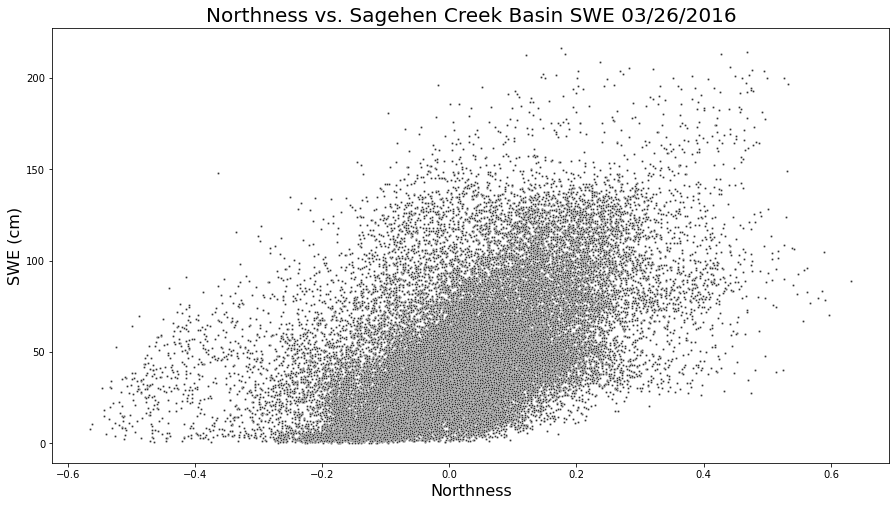

In [190]:
nness_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(data=acc_df, x="nness", y="swe_0326", s=20, color=".2", marker=".")
axes.set_title('Northness vs. Sagehen Creek Basin SWE 03/26/2016', fontsize = 20)
axes.set_xlabel('Northness', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 16)
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

nness_SWE_scatter.savefig('SCB/stats/figures/nness_SWE_0326_scatter.png',transparent=True,bbox_inches='tight')


In [360]:
elev_bins_arr = acc_df['elev_bins'].unique()
elev_bins_arr_sort = [elev_bins_arr.categories[0],elev_bins_arr.categories[1], elev_bins_arr.categories[2],elev_bins_arr.categories[3],elev_bins_arr.categories[4],elev_bins_arr.categories[5]] # create a new list with sorted values

In [362]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'nness_bins', 'elev_bins',
       'fVeg_bins'],
      dtype='object')

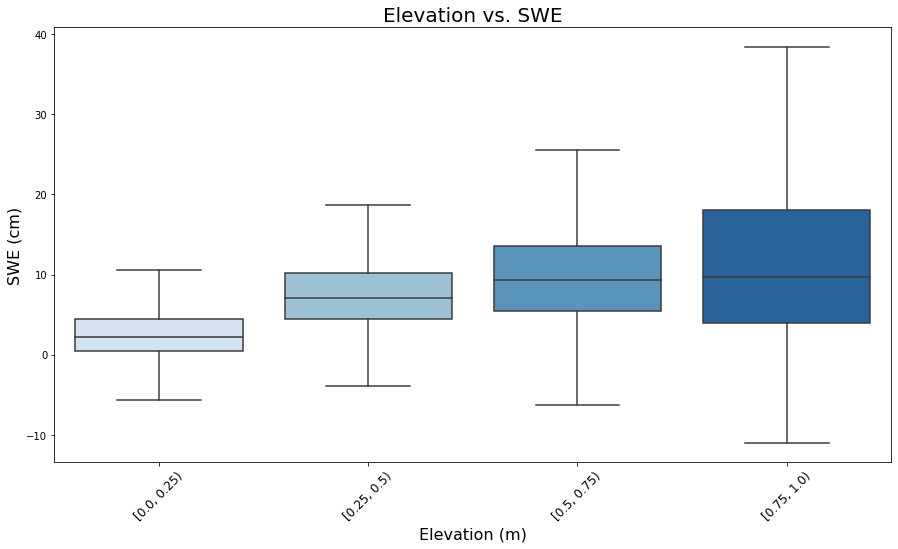

In [364]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=acc_df, x='fVeg_bins', y="delta_acc_ASO",showfliers = False,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Elevation vs. SWE', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

elev_SWE_box.savefig('SCB/stats/figures/elev_SWE_0326_box.png',transparent=True,bbox_inches='tight')

In [483]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

In [510]:
acc_df['elev_rnd'] = (round(acc_df.elev/100))*100

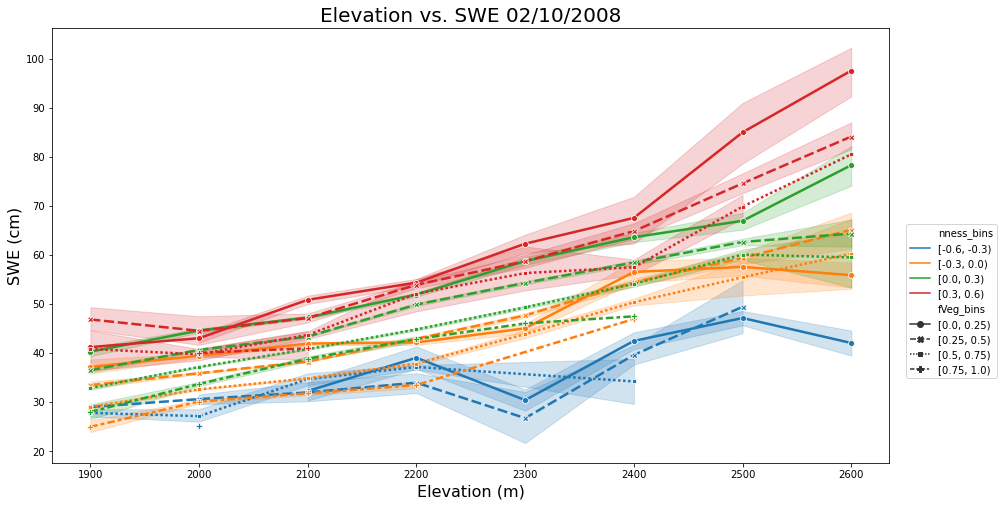

In [538]:


elev_SWE_line, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.lineplot(x=acc_df['elev_rnd'],y=acc_df['swe_080210'], hue=acc_df["nness_bins"],style =acc_df["fVeg_bins"],  linewidth=2.5,markers=True)
axes.set_title('Elevation vs. SWE 02/10/2008', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0);

#elev_SWE_line.savefig('SCB/stats/figures/elev_SWE_line_08_huenness.png',transparent=True,bbox_inches='tight')

# Regressions

In [262]:
# with sklearn, run single variable regression
# a downside of this approach is that the input dataframe contains unnecessary data. For now, that's okay
# input: dataframe - pandas dataframe with ind and dep variables
# input: var1 & var2 - independent and dependent variable names (str)
# output: regr_model - sklearn LinearRegreassion()
# output: regression_df - dataframe with residual value
def sing_var_regress(dataframe, var1, var2):
    # establish ind. and dep. variables
    regression_df = dataframe[[var1,var2]].dropna(subset=[var1,var2])
    ind_df = regression_df[[var1]]
    dep_df = regression_df[[var2]]
    # run regression model 
    regr_model = linear_model.LinearRegression()
    regr_model.fit(ind_df,dep_df)
    # calculate residuals
    residual_var = dep_df.values - regr_model.predict(ind_df)
    predicted_var = regr_model.predict(ind_df)
    regression_df.insert(len(regression_df.columns), "residual_var", residual_var, True)
    regression_df.insert(len(regression_df.columns), "predicted_var", predicted_var, True)

    return regr_model, regression_df

In [391]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

In [452]:
abl_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'abl_MarApr', 'abl_MarMay',
       'abl_AprMay', 'delta_abl_MarApr', 'delta_abl_MarMay',
       'delta_abl_AprMay', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

In [473]:
regr_model, regression_df = sing_var_regress(abl_df, 'elev', 'abl_AprMay')
print('r-squared: \n',r2_score(regression_df['abl_AprMay'],regr_model.predict(regression_df[['elev']])))

r-squared: 
 0.4122890788259671


In [319]:
#sns.scatterplot(data=regression_df, x="elev", y="residual_var")

In [393]:
# using statsmodel
regression_df = acc_df[["elev","delta_acc_ASO"]].dropna(subset=['elev','delta_acc_ASO'])
Y = regression_df['delta_acc_ASO']
X = sm.add_constant(regression_df['elev']) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          delta_acc_ASO   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.663
Date:                Mon, 18 Apr 2022   Prob (F-statistic):              0.197
Time:                        01:05:58   Log-Likelihood:            -1.3454e+05
No. Observations:               38819   AIC:                         2.691e+05
Df Residuals:                   38817   BIC:                         2.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8851      0.570    -12.089      0.0